# Advanced Profile Creation
Creates profiles from parallel lines created in `parallel_transit_lines-Dev` notebook and a digital elevation model. Extends the profile creation from `basic_profile_creation-Dev` to include the transportation route and the location of the NHD streamline.

Assumes transportation routes, from the National Transportation Dataset, align well with elevation data, from the Best Available Topographic dataset.

### Author
John Wall (jwall@Dewberry.com)

### Import libraries

In [28]:
import pandas as pd
import geopandas as gpd

import shapely
from shapely import geometry, ops
from shapely.geometry import Point

import rasterio
from rasterio.plot import show

from matplotlib import pyplot as plt

from rasterstats import zonal_stats, point_query

### Load data

In [29]:
streams = "/mnt/c/gis/fcast_data/sample_streams.shp"
roads = "/mnt/c/gis/fcast_data/sample_roads.shp"
dem = "/mnt/c/gis/fcast_data/tiffs/c67567_aoi.tif"

### Create parallel lines from transportation routes

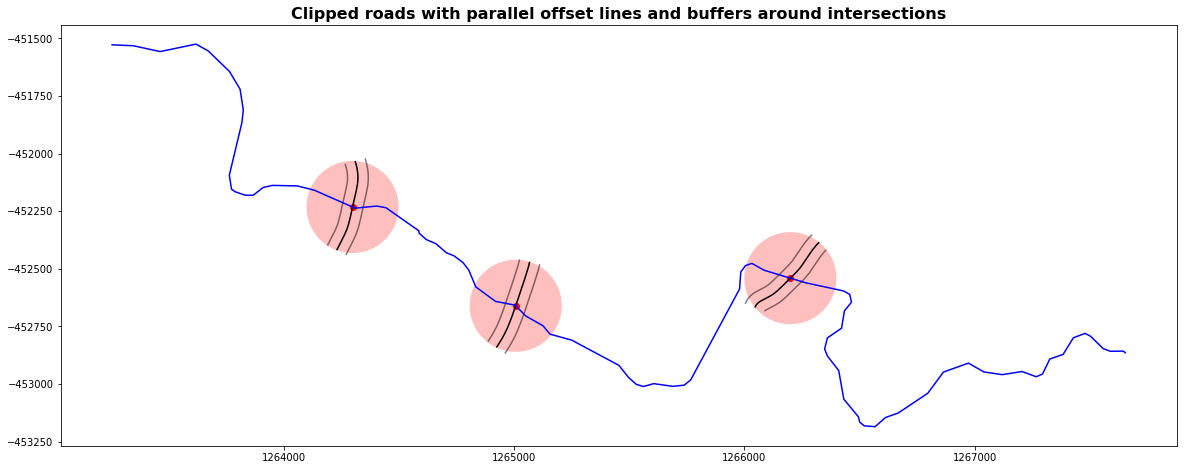

In [30]:
gdf_streams = gpd.read_file(streams)
gdf_roads = gpd.read_file(roads)

stream_prj = gdf_streams.to_crs(gdf_roads.crs)
stream_shape = list(stream_prj.geometry)[0]
gdf_roads_diss = gdf_roads.dissolve(by='FULL_STREE')

intersecting_roads = gdf_roads_diss[gdf_roads_diss.geometry.apply(lambda row: stream_shape.intersects(row))].copy()
intersections = intersecting_roads.geometry.apply(lambda row: stream_shape.intersection(row))
intersection_buffers = intersections.buffer(200)

clipped_roads = intersection_buffers.intersection(intersecting_roads)

# Updated here to be a dictionary
single_lines = {}
for i, road in enumerate(clipped_roads):
    if type(road) is shapely.geometry.multilinestring.MultiLineString:
        single_lines[clipped_roads.index[i]] = ops.linemerge(road)
    else:
        single_lines[clipped_roads.index[i]] = road

offset_lines = {}
for street, line in single_lines.items():
    for side in ['left', 'right']:
        key_name = '_'.join([street, side])
        offset_lines[key_name] = line.parallel_offset(45, side, resolution=1)
        
gdf_roads = gpd.GeoDataFrame(offset_lines.items(), columns=['streets','geometry'])

# Showcase the results
fig, ax = plt.subplots(figsize = (20,8))
clipped_roads.plot(color='k', ax=ax);
gdf_roads.plot(color='k', alpha=0.5, ax=ax);
stream_prj.plot(color='b', ax=ax);
intersections.plot(color='r', ax=ax);
intersection_buffers.plot(color='r', alpha=0.25, ax=ax);
ax.set_title("Clipped roads with parallel offset lines and buffers around intersections", fontsize=16, fontweight='bold');

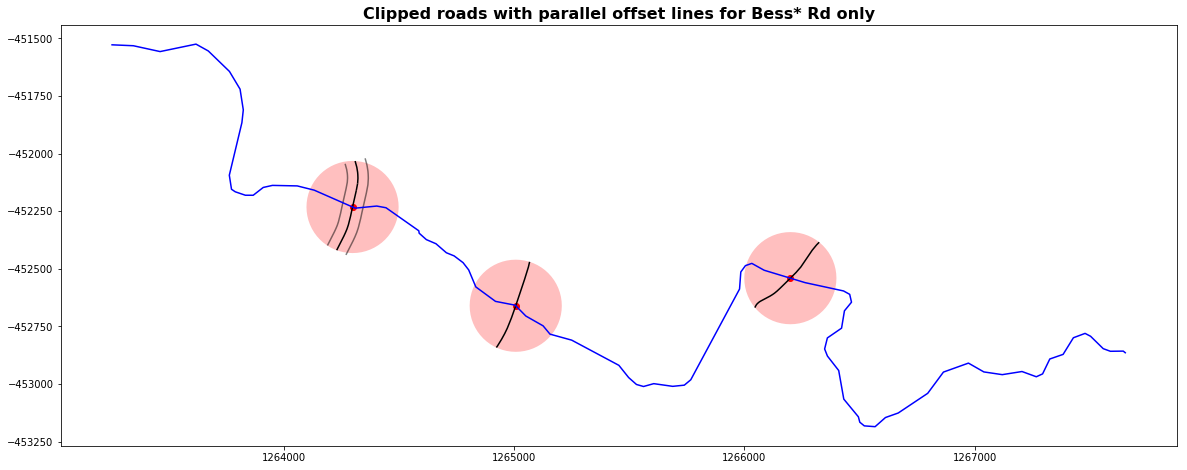

In [31]:
# Sample out street
gdf_sample = gdf_roads[gdf_roads['streets'].str.contains('Bess')]

# Showcase the results for Bess* road
fig, ax = plt.subplots(figsize = (20,8))
clipped_roads.plot(color='k', ax=ax);
gdf_sample.plot(color='k', alpha=0.5, ax=ax); # Inline sampling
stream_prj.plot(color='b', ax=ax);
intersections.plot(color='r', ax=ax);
intersection_buffers.plot(color='r', alpha=0.25, ax=ax);
ax.set_title("Clipped roads with parallel offset lines for Bess* Rd only", fontsize=16, fontweight='bold');

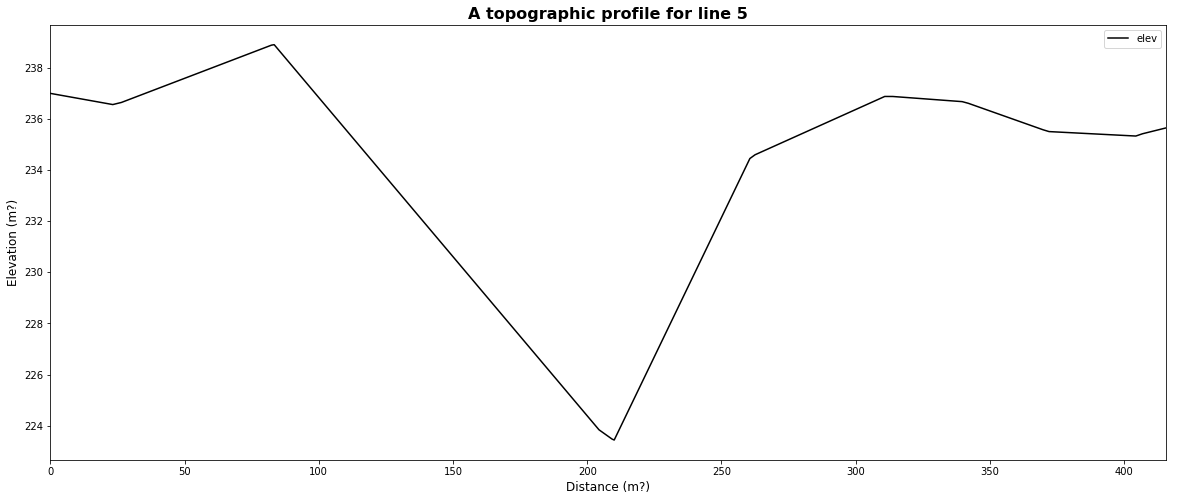

In [32]:
# Create a topographic profile
line_number = 5
profile = point_query(gdf_roads.geometry[line_number], dem)

vertecies = [Point(coord) for coord in gdf_roads.geometry[line_number].coords]
df = pd.DataFrame(vertecies, columns=['point'])
df['elev'] = profile[0]
df['distance'] = [df.point[0].distance(df.point[i]) for i in range(len(df))]

# Showcase the results for Bess* road
fig, ax = plt.subplots(figsize = (20,8))
df.plot(x='distance',y='elev', color='k', ax=ax);
ax.set_ylabel("Elevation (m?)", fontsize=12)
ax.set_xlabel("Distance (m?)", fontsize=12)
ax.set_title("A topographic profile for line {}".format(line_number), fontsize=16, fontweight='bold');

In [33]:
# Define some functions
def multi_to_single_lines(input_lines:gpd.geoseries.GeoSeries) -> dict:
    """Ensures all lines are single part linestrings"""
    single_lines = {}
    for i, line in enumerate(input_lines):
        if type(line) is shapely.geometry.multilinestring.MultiLineString:
            single_lines[input_lines.index[i]] = ops.linemerge(line)
        else:
            single_lines[input_lines.index[i]] = line
    
    return single_lines

def get_topo_profile(line_dict:dict, dem:str) -> pd.core.frame.DataFrame:
    """Creates a topographic profile from a dictionary"""
    line = list(line_dict.values())[0]
    profile = point_query(line, dem)

    vertecies = [Point(coord) for coord in line.coords]
    df = pd.DataFrame(vertecies, columns=['point'])
    df['elev'] = profile[0]
    df['distance'] = [df.point[0].distance(df.point[i]) for i in range(len(df))]
    
    return df

def get_topo_profile_df(line_dict, dem:str) -> pd.core.frame.DataFrame:
    """Creates a topographic profile from a GeoDataFrame of points"""
    line = line_dict.geometry
    profile = point_query(line, dem)

    vertecies = [Point(coord) for coord in line.coords]
    df = pd.DataFrame(vertecies, columns=['point'])
    df['elev'] = profile[0]
    df['distance'] = [df.point[0].distance(df.point[i]) for i in range(len(df))]
    
    return df

In [34]:
# I can't be bothered to remember the full name of this road
rough_name = 'Bess'

# Threshold out this line from the roads
sing_line_dict = multi_to_single_lines(clipped_roads[clipped_roads.index.str.contains(rough_name)])

In [35]:
road_profile = get_topo_profile(sing_line_dict, dem)

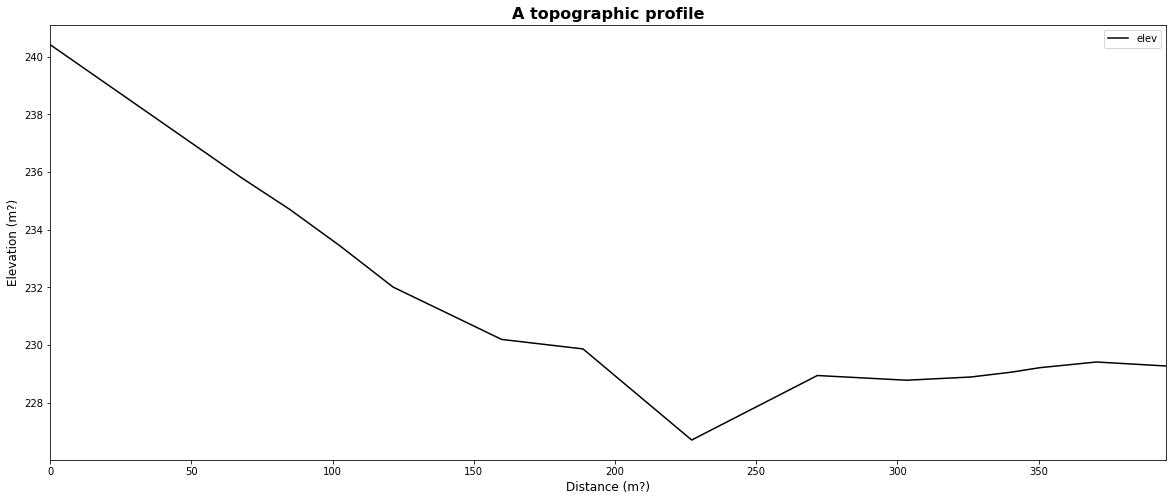

In [36]:
fig, ax = plt.subplots(figsize = (20,8))
road_profile.plot(x='distance',y='elev', color='k', ax=ax);
ax.set_ylabel("Elevation (m?)", fontsize=12)
ax.set_xlabel("Distance (m?)", fontsize=12)
ax.set_title("A topographic profile", fontsize=16, fontweight='bold');

In [37]:
sample_dict = gdf_roads[gdf_roads['streets'].str.contains('Bess')].loc[0]

In [38]:
offset_profile = get_topo_profile_df(sample_dict, dem)

In [39]:
# # Showcase the results for Bess* road
# fig, ax = plt.subplots(figsize = (20,8))
# road_profile.plot(x='distance',y='elev', color='k', ax=ax);
# profile.plot(x='distance',y='elev', color='b', ax=ax);
# ax.set_ylabel("Elevation (m?)", fontsize=12)
# ax.set_xlabel("Distance (m?)", fontsize=12)
# ax.set_title("A topographic profiles for road and offset profile", fontsize=16, fontweight='bold');

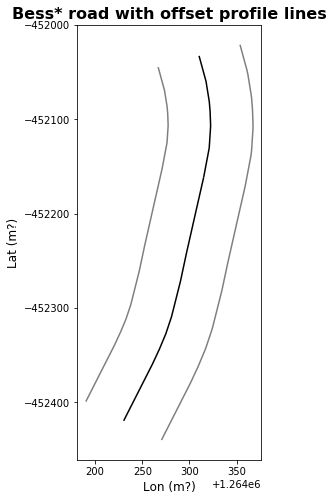

In [40]:
# Double check that roads and profiles match-up
bess_profiles = gdf_roads[gdf_roads['streets'].str.contains('Bess')]

bess_road = gpd.GeoDataFrame(clipped_roads[clipped_roads.index.str.contains(rough_name)], columns=['geometry'])

fig, ax = plt.subplots(figsize=(20,8))
bess_profiles.plot(color='k', alpha=0.5, ax=ax);
bess_road.plot(color='k', ax=ax);
ax.set_ylabel("Lat (m?)", fontsize=12)
ax.set_xlabel("Lon (m?)", fontsize=12)
ax.set_title("Bess* road with offset profile lines", fontsize=16, fontweight='bold');

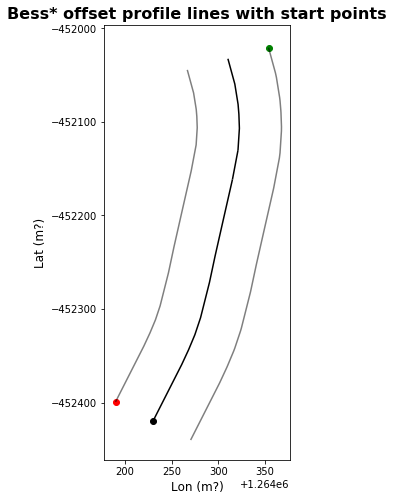

In [41]:
# Split out the road
bess_singleline = multi_to_single_lines(bess_road.geometry)
bess_gdf = gpd.GeoDataFrame(bess_singleline.items(), columns=['road', 'geometry'])

# Determine which vertex is the first one
vertecies_road = [Point(coord) for coord in bess_gdf.geometry[0].coords]
vertecies_left = [Point(coord) for coord in bess_profiles.geometry[0].coords]
vertecies_right = [Point(coord) for coord in bess_profiles.geometry[1].coords]

road_start = gpd.GeoDataFrame(vertecies_road[0:1], columns=['geometry'])
left_start = gpd.GeoDataFrame(vertecies_left[0:1], columns=['geometry'])
right_start = gpd.GeoDataFrame(vertecies_right[0:1], columns=['geometry'])

# Showcase results
fig, ax = plt.subplots(figsize=(20,8))

bess_profiles.plot(color='k', alpha=0.5, ax=ax);
bess_road.plot(color='k', ax=ax);

road_start.plot(color='k', ax=ax);
left_start.plot(color='r', ax=ax);
right_start.plot(color='g', ax=ax);

ax.set_ylabel("Lat (m?)", fontsize=12)
ax.set_xlabel("Lon (m?)", fontsize=12)
ax.set_title("Bess* offset profile lines with start points", fontsize=16, fontweight='bold');

In [42]:
def get_topo_from_line(line:str, dem:str) -> pd.core.frame.DataFrame:
    """Identifies the elevation of a point from a shapely linestring from
        a digital elevation model.
    """
    profile = point_query(line, dem)

    vertecies = [Point(coord) for coord in line.coords]
    df = pd.DataFrame(vertecies, columns=['point'])
    df['elev'] = profile[0]
    df['distance'] = [df.point[0].distance(df.point[i]) for i in range(len(df))]
    
    return df

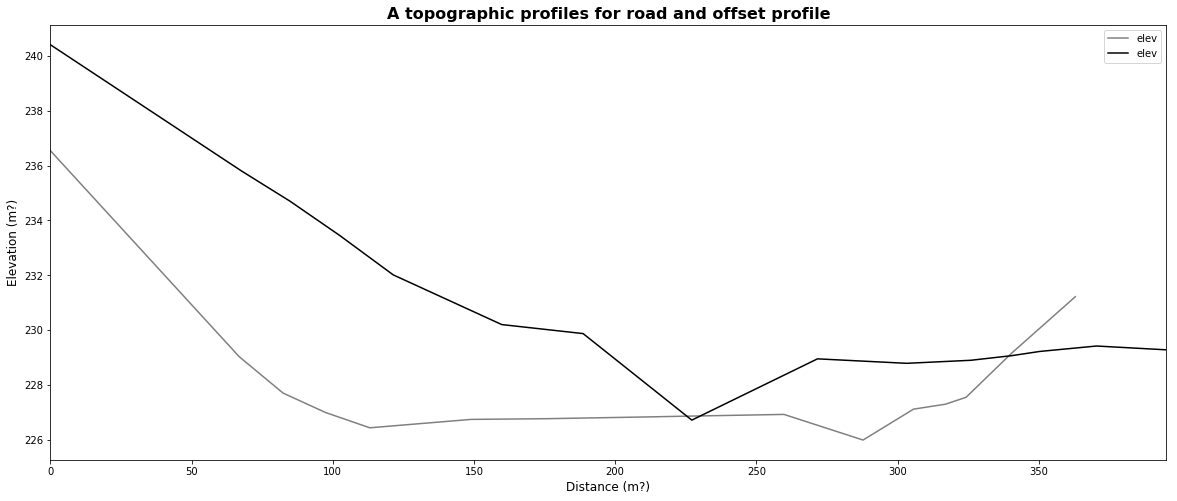

In [43]:
# Obtain topographic profiles
left_offset_profile = get_topo_from_line(bess_profiles.geometry[0], dem)
road_profile = get_topo_from_line(bess_gdf.geometry[0], dem)

# Showcase the results for Bess* road
fig, ax = plt.subplots(figsize = (20,8))
left_offset_profile.plot(x='distance',y='elev', color='k', alpha=0.5, ax=ax);
road_profile.plot(x='distance',y='elev', color='k', ax=ax);
ax.set_ylabel("Elevation (m?)", fontsize=12)
ax.set_xlabel("Distance (m?)", fontsize=12)
ax.set_title("A topographic profiles for road and offset profile", fontsize=16, fontweight='bold');

From the above, we want to compare the profiles between the road and the offset cross sections; however we are unable to do so setting the initial vertex as zero distance for both profiles. This conflates the distance along the profile and the relative position of the profiles to one another. Distance should therefore be latitute.

The additional benefit is that orientation of the profile does not matter.

Latitutde as distance, however, is problematic when the profile is along latitude (as might be seen in the midwest). A variance in latitude could be checks to determine longitude needs to be plotted opposed to latitude.

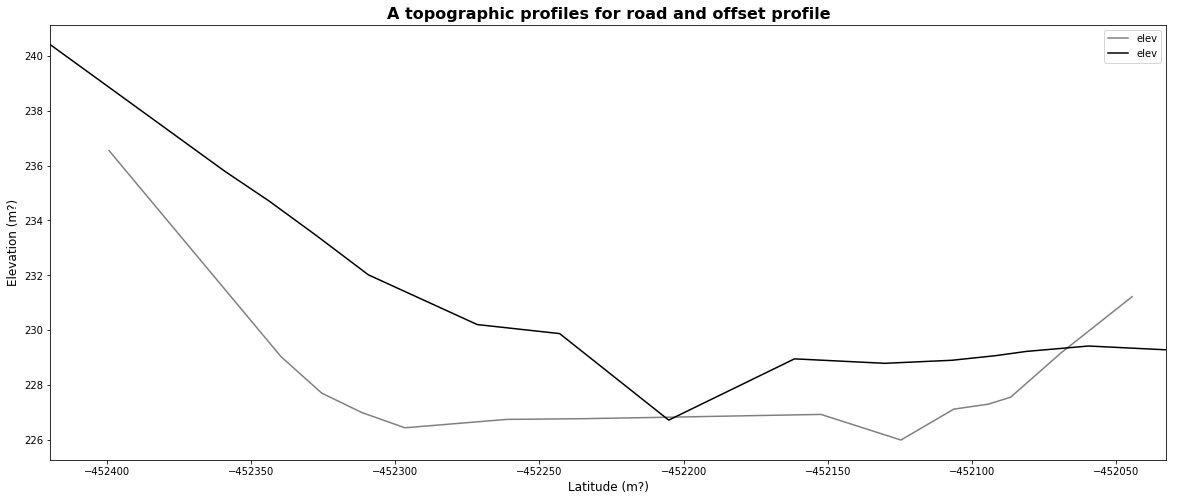

In [44]:
# Grab latitudes
left_offset_profile['lat'] = left_offset_profile.point.apply(lambda point: point.y)
road_profile['lat'] = road_profile.point.apply(lambda point: point.y)

# Showcase the results for Bess* road
fig, ax = plt.subplots(figsize = (20,8))
left_offset_profile.plot(x='lat',y='elev', color='k', alpha=0.5, ax=ax);
road_profile.plot(x='lat',y='elev', color='k', ax=ax);
ax.set_ylabel("Elevation (m?)", fontsize=12)
ax.set_xlabel("Latitude (m?)", fontsize=12)
ax.set_title("A topographic profiles for road and offset profile", fontsize=16, fontweight='bold');

In [45]:
# Outline basic workflow for choosing lats vs lons
def plot_lat_or_long(df:pd.core.frame.DataFrame, threshold:int) -> None:
    """Basic logic to determine if lats or lons should be plotted"""
    lats = [point.y for point in road_profile.point]
    delta_lat = max(lats) - min(lats)
    if delta_lat >= threshold:
        print("Use lats")
    else:
        print("Use lons")
        
plot_lat_or_long(road_profile, 100)

Use lats


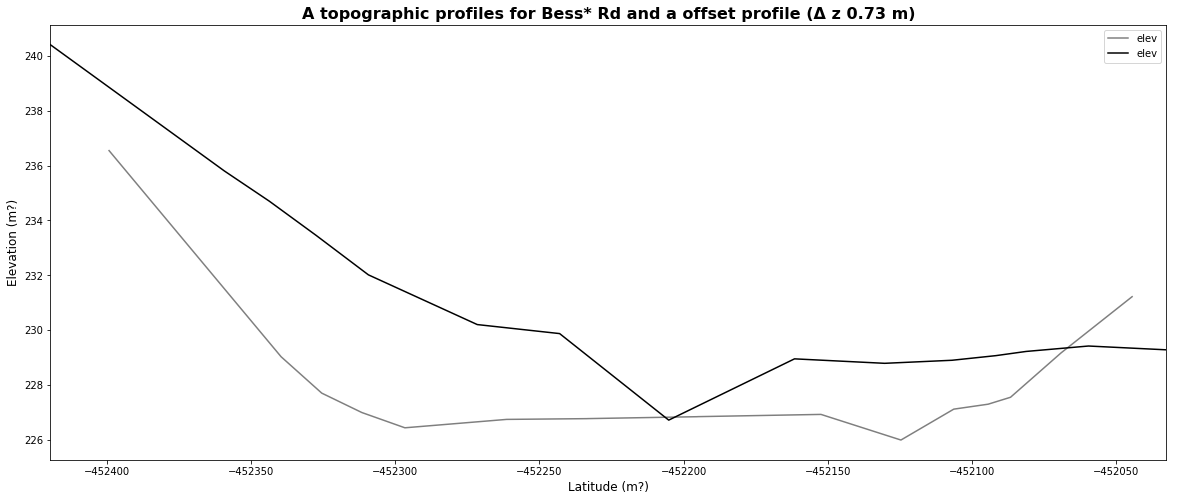

In [48]:
# Get the delta-elevation and report that for the profile
offset_min = min(left_offset_profile.elev)
road_min = min(road_profile.elev)
delta_z = round(road_min - offset_min, 2)

# Showcase the results for Bess* road
fig, ax = plt.subplots(figsize = (20,8))
left_offset_profile.plot(x='lat',y='elev', color='k', alpha=0.5, ax=ax);
road_profile.plot(x='lat',y='elev', color='k', ax=ax);
ax.set_ylabel("Elevation (m?)", fontsize=12)
ax.set_xlabel("Latitude (m?)", fontsize=12)
ax.set_title("A topographic profiles for Bess* Rd and a offset profile (\u0394 z {} m)".format(delta_z),
             fontsize=16, fontweight='bold');

The above shows that the delta-elevation might be missreported due to burning in the stream-path to the elevation data.

How can this be resolved?

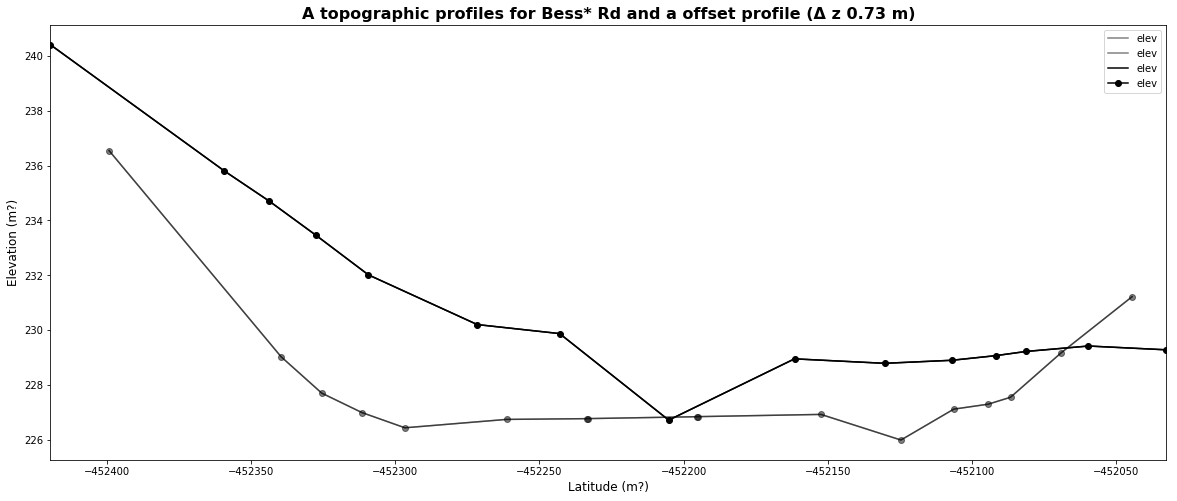

In [56]:
# Showcase the results for Bess* road
fig, ax = plt.subplots(figsize = (20,8))
left_offset_profile.plot(x='lat',y='elev', color='k', alpha=0.5, ax=ax);
left_offset_profile.plot(x='lat',y='elev', color='k', marker='o', alpha=0.5, ax=ax);
road_profile.plot(x='lat',y='elev', color='k', ax=ax);
road_profile.plot(x='lat',y='elev', color='k', marker='o', ax=ax);
ax.set_ylabel("Elevation (m?)", fontsize=12)
ax.set_xlabel("Latitude (m?)", fontsize=12)
ax.set_title("A topographic profiles for Bess* Rd and a offset profile (\u0394 z {} m)".format(delta_z),
             fontsize=16, fontweight='bold');

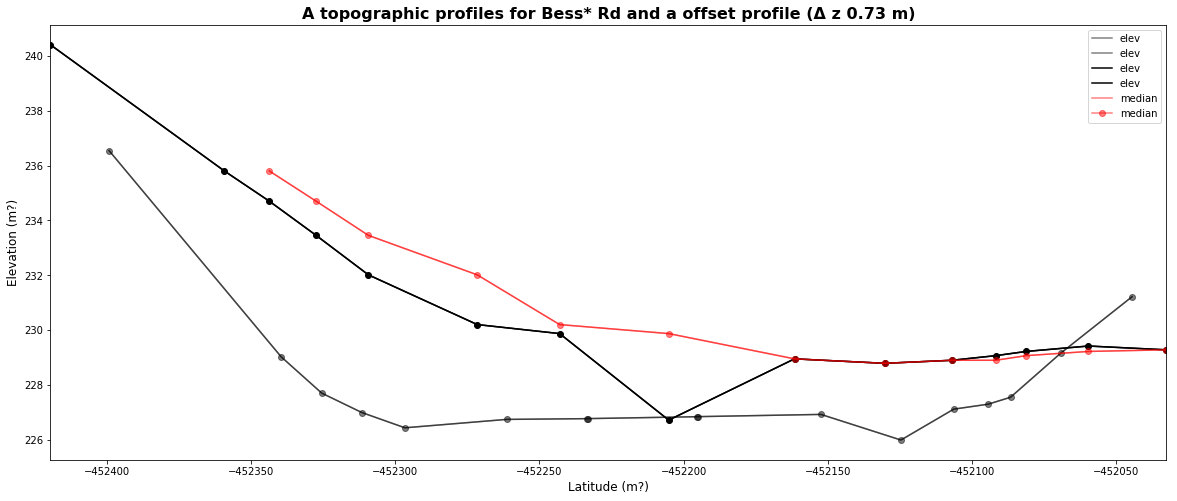

In [89]:
fig, ax = plt.subplots(figsize = (20,8))

left_offset_profile.plot(x='lat',y='elev', color='k', alpha=0.5, ax=ax);
left_offset_profile.plot(x='lat',y='elev', color='k', marker='o', alpha=0.5, ax=ax);

road_profile.plot(x='lat',y='elev', color='k', ax=ax);
road_profile.plot(x='lat',y='elev', color='k', marker='o', ax=ax);

# Use a rolling median filter for every three points
road_profile['median'] = road_profile.elev.rolling(3).median()
road_profile.plot(x='lat',y='median', color='r', alpha=0.5, ax=ax);
road_profile.plot(x='lat',y='median', color='r', alpha=0.5, marker='o', ax=ax);

ax.set_ylabel("Elevation (m?)", fontsize=12)
ax.set_xlabel("Latitude (m?)", fontsize=12)
ax.set_title("A topographic profiles for Bess* Rd and a offset profile (\u0394 z {} m)".format(delta_z),
             fontsize=16, fontweight='bold');

In [103]:
road_profile.dropna(inplace=True)
road_profile['z_delta'] = abs(road_profile['median'] - road_profile['elev'])
road_profile.drop(road_profile[road_profile['z_delta'] > 2].index, inplace=True)
road_profile

,point,elev,distance,lat,mean,median,z_delta
2,POINT (1264268.136142546 -452343.6432617329),234.704082,84.862795,-452343.643262,235.807607,235.807607,1.103525
3,POINT (1264274.928856462 -452327.4133352485),233.455410,102.424868,-452327.413335,234.704082,234.704082,1.248672
4,POINT (1264280.987859814 -452309.2840669414),232.014200,121.406452,-452309.284067,233.455410,233.455410,1.441210
5,POINT (1264290.516880784 -452271.5352234888),230.198795,159.842131,-452271.535223,232.014200,232.014200,1.815406
6,POINT (1264296.599644995 -452242.9755080168),229.869609,188.657657,-452242.975508,230.198795,230.198795,0.329185
8,POINT (1264315.073853319 -452161.5262819163),228.947216,271.638477,-452161.526282,228.947216,228.947216,0.000000
9,POINT (1264320.995156646 -452130.2665852857),228.784150,303.212388,-452130.266585,228.784150,228.784150,0.000000
10,POINT (1264322.486686544 -452106.9283118515),228.895315,325.974966,-452106.928312,228.895315,228.895315,0.000000
11,POINT (1264321.938083162 -452091.7296166392),229.064112,340.431663,-452091.729617,228.895315,228.895315,0.168797
12,POINT (1264321.074145396 -452081.2012426882),229.217793,350.357613,-452081.201243,229.064112,229.064112,0.153681


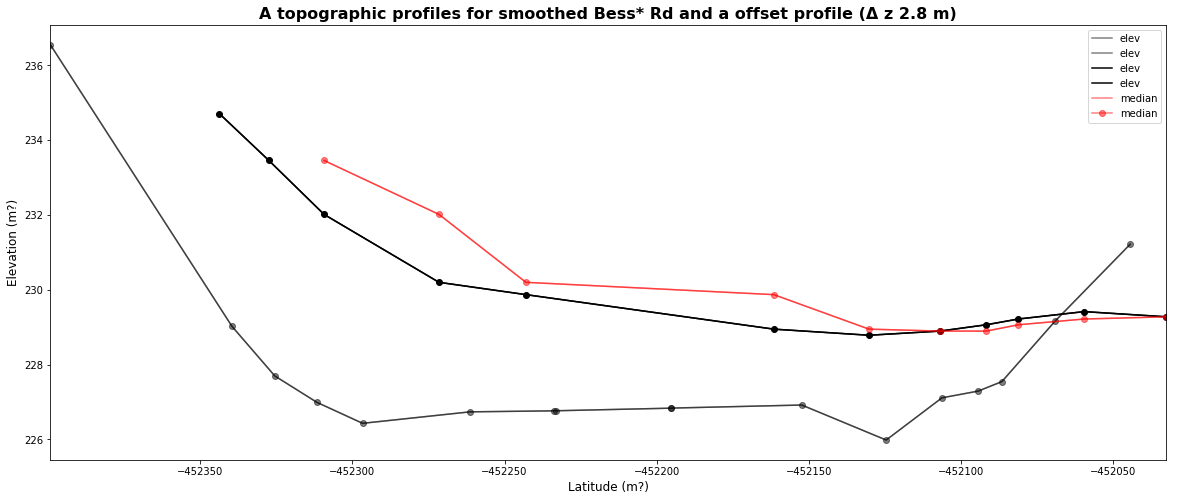

In [106]:
offset_min = min(left_offset_profile.elev)
road_min = min(road_profile.elev)
delta_z = round(road_min - offset_min, 2)

fig, ax = plt.subplots(figsize = (20,8))

left_offset_profile.plot(x='lat',y='elev', color='k', alpha=0.5, ax=ax);
left_offset_profile.plot(x='lat',y='elev', color='k', marker='o', alpha=0.5, ax=ax);

road_profile.plot(x='lat',y='elev', color='k', ax=ax);
road_profile.plot(x='lat',y='elev', color='k', marker='o', ax=ax);

# Use a rolling median filter for every three points
road_profile['median'] = road_profile.elev.rolling(3).median()
road_profile.plot(x='lat',y='median', color='r', alpha=0.5, ax=ax);
road_profile.plot(x='lat',y='median', color='r', alpha=0.5, marker='o', ax=ax);

ax.set_ylabel("Elevation (m?)", fontsize=12)
ax.set_xlabel("Latitude (m?)", fontsize=12)
ax.set_title("A topographic profiles for smoothed Bess* Rd and a offset profile (\u0394 z {} m)".format(delta_z),
             fontsize=16, fontweight='bold');